In [ ]:
! pip install catboost
from catboost import CatBoostClassifier

# Import

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler,TargetEncoder
from sklearn.metrics import (classification_report, confusion_matrix, recall_score,
                            accuracy_score, f1_score, roc_auc_score)
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score,mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
import xgboost as xgb
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from lightgbm import LGBMClassifier

from scipy.stats import chi2_contingency, pointbiserialr, spearmanr
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cleaned_dataset_path = "/content/drive/MyDrive/DM and ML/DM&ML Project/"

import os

for file in os.listdir(cleaned_dataset_path):
    print(file)


crime_data_sample.csv
cleaned_crime_data.csv


In [ ]:
df = pd.read_csv(os.path.join(cleaned_dataset_path, "cleaned_crime_data.csv"))

In [ ]:
df.columns

Index(['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME',
       'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes',
       'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc',
       'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'LOCATION',
       'LAT', 'LON', 'year', 'month', 'day', 'day_of_week', 'day_name',
       'month_name', 'hour', 'minute', 'time_category', 'season', 'age_group',
       'is_used_weapon', 'is_human_victim', 'TIME_OCC_PAD', 'Mocodes_Count',
       'area_risk_level', 'area_risk_level_numeric', 'area_risk_score'],
      dtype='object')

In [ ]:
df.head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,time_category,season,age_group,is_used_weapon,is_human_victim,TIME_OCC_PAD,Mocodes_Count,area_risk_level,area_risk_level_numeric,area_risk_score
0,220708935,2022-05-08,2022-05-06,16:20,7,Wilshire,762,1,6.236370,VEHICLE - STOLEN,...,Afternoon,Spring,Minor (0-17),0,0,1620,0.000000,High Risk,3,65.608545
1,231010095,2023-06-08,2023-06-08,09:15,10,West Valley,1023,2,6.437752,BATTERY - SIMPLE ASSAULT,...,Morning,Summer,Mature (50-64),1,1,915,1.791759,Low Risk,1,55.138927
2,231806002,2023-02-08,2023-02-03,10:05,18,Southeast,1804,2,5.872118,THEFT OF IDENTITY,...,Morning,Winter,Middle Age (35-49),0,1,1005,1.098612,Medium Risk,2,58.581464
3,231220210,2023-09-25,2023-09-25,11:00,12,77th Street,1268,1,6.255750,VEHICLE - ATTEMPT STOLEN,...,Morning,Automn,Middle Age (35-49),1,0,1100,1.609438,Very High Risk,4,67.423544
4,201409662,2020-04-13,2020-04-13,05:00,14,Pacific,1494,1,6.089045,THEFT PLAIN - PETTY ($950 & UNDER),...,Night,Spring,Middle Age (35-49),0,0,500,1.098612,Very High Risk,4,78.938209


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200251 entries, 0 to 200250
Data columns (total 41 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   DR_NO                    200251 non-null  int64  
 1   Date Rptd                200251 non-null  object 
 2   DATE OCC                 200251 non-null  object 
 3   TIME OCC                 200251 non-null  object 
 4   AREA                     200251 non-null  int64  
 5   AREA NAME                200251 non-null  object 
 6   Rpt Dist No              200251 non-null  int64  
 7   Part 1-2                 200251 non-null  int64  
 8   Crm Cd                   200251 non-null  float64
 9   Crm Cd Desc              200251 non-null  object 
 10  Mocodes                  200251 non-null  object 
 11  Vict Age                 200251 non-null  int64  
 12  Vict Sex                 200251 non-null  object 
 13  Vict Descent             200251 non-null  object 
 14  Prem

In [ ]:

def calculate_correlation(col, target_col):

    if pd.api.types.is_numeric_dtype(col):
        corr, _ = spearmanr(col, target_col, nan_policy='omit')
        return corr

    else:
        confusion_matrix = pd.crosstab(col, target_col)
        chi2 = chi2_contingency(confusion_matrix)[0]
        n = confusion_matrix.sum().sum()
        phi2 = chi2 / n
        r, k = confusion_matrix.shape
        return np.sqrt(phi2 / min((k-1), (r-1)))

In [ ]:

df_analysis = df.copy()

correlation_results = {}

for column in df_analysis.columns:
    if column != target and column != 'area_risk_level_numeric':
        try:
            corr_value = calculate_correlation(df_analysis[column], df_analysis[target])
            correlation_results[column] = corr_value
        except Exception as e:
            correlation_results[column] = np.nan
            print(f"Error calculating correlation for {column}: {str(e)}")

correlation_df = pd.DataFrame.from_dict(correlation_results, orient='index', columns=['Correlation_with_Risk'])
correlation_df = correlation_df.sort_values(by='Correlation_with_Risk', ascending=False)

In [ ]:
print("أقوى 10 سمات ارتباطاً بمستوى الخطورة:")
print(correlation_df.head(10))

print("\nأضعف 10 سمات ارتباطاً بمستوى الخطورة:")
print(correlation_df.tail(10))

أقوى 10 سمات ارتباطاً بمستوى الخطورة:
                 Correlation_with_Risk
AREA NAME                     1.000000
area_risk_level               1.000000
area_risk_score               0.968117
LOCATION                      0.966167
Mocodes                       0.664377
LON                           0.249621
Premis Desc                   0.187732
Vict Descent                  0.123181
Date Rptd                     0.106191
DATE OCC                      0.101922

أضعف 10 سمات ارتباطاً بمستوى الخطورة:
                 Correlation_with_Risk
is_human_victim              -0.000896
TIME_OCC_PAD                 -0.007589
hour                         -0.008640
Crm Cd                       -0.019040
Part 1-2                     -0.019904
Vict Age                     -0.019913
DR_NO                        -0.042232
Rpt Dist No                  -0.268448
AREA                         -0.268783
LAT                          -0.405966


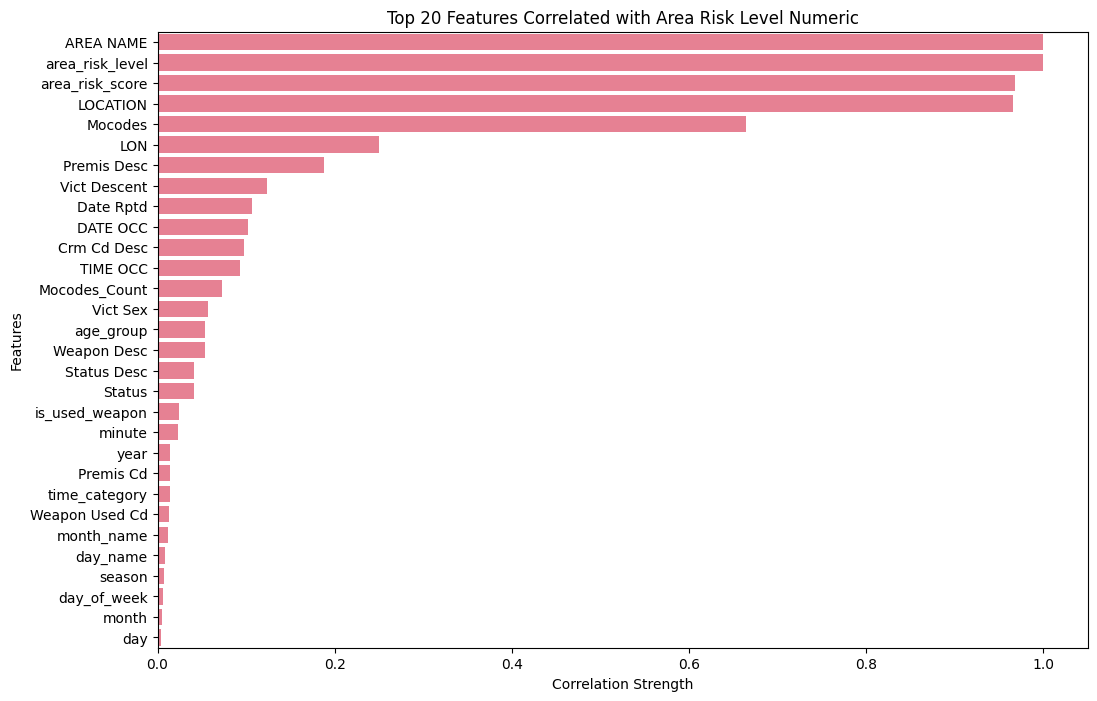

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
top_features = correlation_df.head(30)
sns.barplot(x=top_features['Correlation_with_Risk'], y=top_features.index)
plt.title('Top 20 Features Correlated with Area Risk Level Numeric')
plt.xlabel('Correlation Strength')
plt.ylabel('Features')
plt.show()

# Selected Featured

In [ ]:

selected_features = [
    'LOCATION',
    'Mocodes',
    # 'LON',
    'Premis Desc',
    'Vict Descent',
    'Date Rptd',
    'DATE OCC',
    'Crm Cd Desc',
    # 'LAT',
    'Vict Age',
    'TIME OCC',
    'Crm Cd',
    'Weapon Desc'
]

X = df[selected_features]
y = df['area_risk_level_numeric']


X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5 , random_state=42)

numeric_features = ['Vict Age', 'Crm Cd']

categorical_features = [
    'LOCATION',
    'Mocodes',
    'Premis Desc',
    'Vict Descent',
    'Date Rptd',
    'DATE OCC',
    'Crm Cd Desc',
    'Weapon Desc',
    'TIME OCC'
]
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),

    ])

# BaseLine Models

## Random Forest

In [ ]:
best_params = {
    'n_estimators': 100,          # عدد الأشجار في الغابة
    'max_depth': None,            # لا تقييد عمق الشجرة (اتركها تنمو كاملة)
    'min_samples_split': 5,       # الحد الأدنى لعينات الانقسام في العقدة
    'min_samples_leaf': 2,        # الحد الأدنى لعينات في الورقة
    'max_features': 'sqrt',       # عدد السمات للنظر فيها في كل انقسام
    'bootstrap': True,            # استخدام bootstrap samples
    'class_weight': 'balanced',   # موازنة الفئات غير المتكافئة
    'random_state': 42,           # للتكرارية
    'n_jobs': -1    ,
    'max_samples': 0.8
}

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(**best_params))
])

rf_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Vict Age', 'Crm Cd']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['LOCATION', 'Mocodes',
                                                   'Premis Desc',
                                                   'Vict Descent', 'Date Rptd',
                                                   'DATE OCC', 'Crm Cd Desc',
                                                   'Weapon Desc',
                                                   'TIME OCC'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        max_samples=0.8, min_samples_leaf=2,
                                        min_samples_split=5, n_jobs=-1,
                                        random_state=42))])

In [ ]:
y_val_pred = rf_pipeline.predict(X_val)

print("Validation Set Performance:")
print(classification_report(y_val, y_val_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

accuracy = accuracy_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred, average='weighted')
roc_auc = roc_auc_score(pd.get_dummies(y_test), pd.get_dummies(y_val_pred), average='weighted')

print(f"\nAccuracy: {accuracy:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")
print(f"ROC AUC Score (weighted): {roc_auc:.4f}")

Validation Set Performance:
              precision    recall  f1-score   support

           1       0.45      0.61      0.51      7191
           2       0.48      0.40      0.44      6588
           3       0.55      0.50      0.52      7432
           4       0.60      0.54      0.56      8827

    accuracy                           0.52     30038
   macro avg       0.52      0.51      0.51     30038
weighted avg       0.52      0.52      0.52     30038


Confusion Matrix:
[[4363 1004  940  884]
 [1847 2650  907 1184]
 [1662  885 3731 1154]
 [1893  976 1216 4742]]

Accuracy: 0.5155
F1 Score (weighted): 0.5150
ROC AUC Score (weighted): 0.5010


In [ ]:
y_test_pred = rf_pipeline.predict(X_test)

print("\nTest Set Performance (Best Model):")
print(classification_report(y_test, y_test_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

accuracy = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred, average='weighted')
roc_auc = roc_auc_score(pd.get_dummies(y_test), pd.get_dummies(y_test_pred), average='weighted')

print(f"\nAccuracy: {accuracy:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")
print(f"ROC AUC Score (weighted): {roc_auc:.4f}")


Test Set Performance (Best Model):
              precision    recall  f1-score   support

           1       0.43      0.59      0.50      6928
           2       0.48      0.41      0.44      6654
           3       0.55      0.50      0.52      7474
           4       0.60      0.54      0.57      8982

    accuracy                           0.51     30038
   macro avg       0.51      0.51      0.51     30038
weighted avg       0.52      0.51      0.51     30038


Confusion Matrix:
[[4119 1012  898  899]
 [1856 2717  957 1124]
 [1698  881 3704 1191]
 [1894 1051 1222 4815]]

Accuracy: 0.5112
F1 Score (weighted): 0.5115
ROC AUC Score (weighted): 0.6747


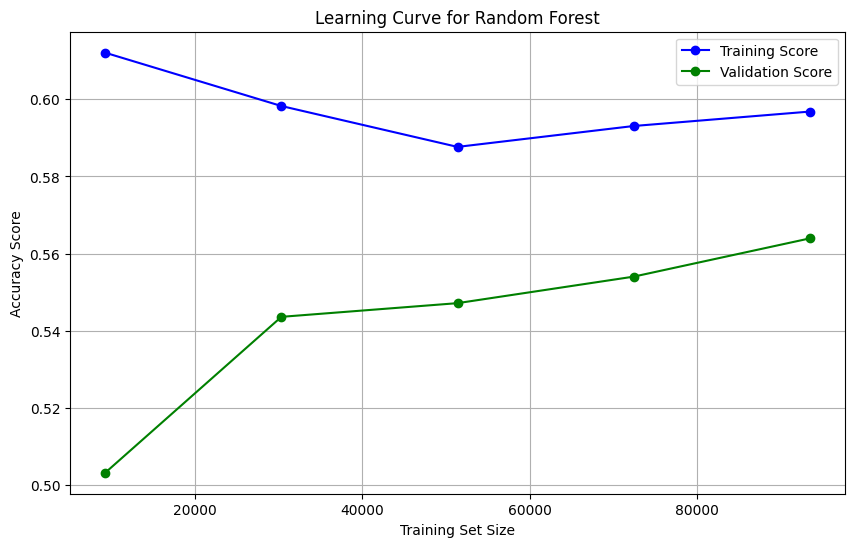

In [ ]:
train_sizes, train_scores, val_scores = learning_curve(
    rf_pipeline,
    X_train,
    y_train,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5),
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)


plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Score')
plt.plot(train_sizes, val_mean, 'o-', color='green', label='Validation Score')
plt.title('Learning Curve for Random Forest')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Score')
plt.legend(loc='best')
plt.grid()
plt.show()

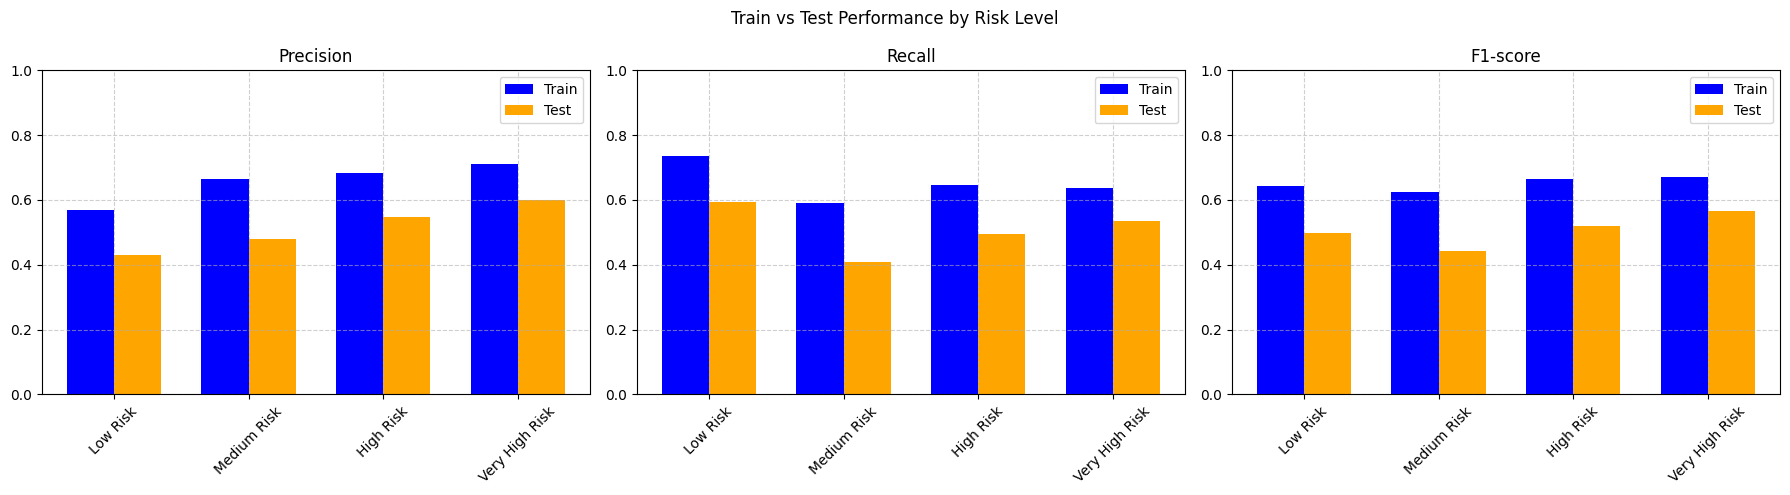

In [ ]:
categories = ['Low Risk', 'Medium Risk', 'High Risk', 'Very High Risk']

train_report = classification_report(y_train, rf_pipeline.predict(X_train), target_names=categories, output_dict=True)
test_report = classification_report(y_test, rf_pipeline.predict(X_test), target_names=categories, output_dict=True)

metrics = ['precision', 'recall', 'f1-score']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, metric in enumerate(metrics):
    train_scores = [train_report[cat][metric] for cat in categories]
    test_scores = [test_report[cat][metric] for cat in categories]

    x = np.arange(len(categories))
    width = 0.35

    axes[i].bar(x - width/2, train_scores, width, label='Train', color='blue')
    axes[i].bar(x + width/2, test_scores, width, label='Test', color='orange')
    axes[i].set_title(metric.capitalize())
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(categories, rotation=45)
    axes[i].legend()
    axes[i].set_ylim(0, 1)
    axes[i].grid(True, linestyle='--', alpha=0.6)

plt.suptitle('Train vs Test Performance by Risk Level')
plt.tight_layout()
plt.show()

## Logistic Regression

In [ ]:
logreg_params = {
    'multi_class': 'multinomial',
    'solver': 'saga',
    'penalty': 'elasticnet',  # مزيج من L1 وL2
    'l1_ratio': 0.5,         # توازن بين L1 وL2
    'C': 0.1,                # زيادة قوة التنظيم (قيمة أصغر)
    'max_iter': 1000,
    'random_state': 42,
    'n_jobs': -1,
    'class_weight': 'balanced',
    'tol': 1e-4,
    'verbose': 1
}

logreg_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', TargetEncoder(), categorical_features),
    ])


logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(**logreg_params))
])

logreg_pipeline.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 28 epochs took 93 seconds


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Vict Age', 'Crm Cd']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['LOCATION', 'Mocodes',
                                                   'Premis Desc',
                                                   'Vict Descent', 'Date Rptd',
                                                   'DATE OCC', 'Crm Cd Desc',
                                                   'Weapon Desc',
                                                   'TIME OCC'])])),
                ('classifier',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    l1_ratio=0.5, max_iter=1000,
                                    multi_class='multinomial', n_jobs=-1,
                                    penalty='elasticnet', random_state=42,
                                    solver='saga', verbose=1))])

In [ ]:
y_val_pred = logreg_pipeline.predict(X_val)

print("Validation Set Performance:")
print(classification_report(y_val, y_val_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

accuracy = accuracy_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred, average='weighted')
roc_auc = roc_auc_score(pd.get_dummies(y_test), pd.get_dummies(y_val_pred), average='weighted')

print(f"\nAccuracy: {accuracy:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")
print(f"ROC AUC Score (weighted): {roc_auc:.4f}")


Validation Set Performance:
              precision    recall  f1-score   support

           1       0.46      0.66      0.54      7191
           2       0.54      0.48      0.51      6588
           3       0.61      0.55      0.58      7432
           4       0.68      0.54      0.60      8827

    accuracy                           0.56     30038
   macro avg       0.57      0.56      0.56     30038
weighted avg       0.58      0.56      0.56     30038


Confusion Matrix:
[[4757  926  835  673]
 [1913 3165  746  764]
 [1687  840 4069  836]
 [2001  978 1048 4800]]

Accuracy: 0.5590
F1 Score (weighted): 0.5608
ROC AUC Score (weighted): 0.4987


In [ ]:
y_test_pred = logreg_pipeline.predict(X_test)

print("\nTest Set Performance (Best Model):")
print(classification_report(y_test, y_test_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

accuracy = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred, average='weighted')
roc_auc = roc_auc_score(pd.get_dummies(y_test), pd.get_dummies(y_test_pred), average='weighted')

print(f"\nAccuracy: {accuracy:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")
print(f"ROC AUC Score (weighted): {roc_auc:.4f}")


Test Set Performance (Best Model):
              precision    recall  f1-score   support

           1       0.44      0.66      0.53      6928
           2       0.52      0.47      0.50      6654
           3       0.61      0.55      0.58      7474
           4       0.68      0.54      0.60      8982

    accuracy                           0.55     30038
   macro avg       0.57      0.55      0.55     30038
weighted avg       0.57      0.55      0.56     30038


Confusion Matrix:
[[4540  970  751  667]
 [1962 3138  805  749]
 [1689  859 4104  822]
 [2028 1026 1072 4856]]

Accuracy: 0.5539
F1 Score (weighted): 0.5565
ROC AUC Score (weighted): 0.7047


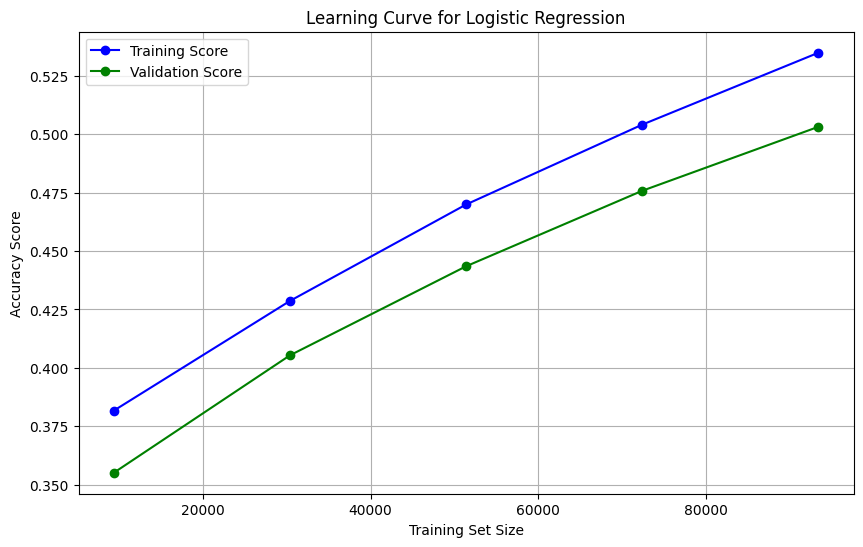

In [ ]:
train_sizes, train_scores, val_scores = learning_curve(
    logreg_pipeline,
    X_train,
    y_train,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5),
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)


plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Score')
plt.plot(train_sizes, val_mean, 'o-', color='green', label='Validation Score')
plt.title('Learning Curve for Logistic Regression')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Score')
plt.legend(loc='best')
plt.grid()
plt.show()

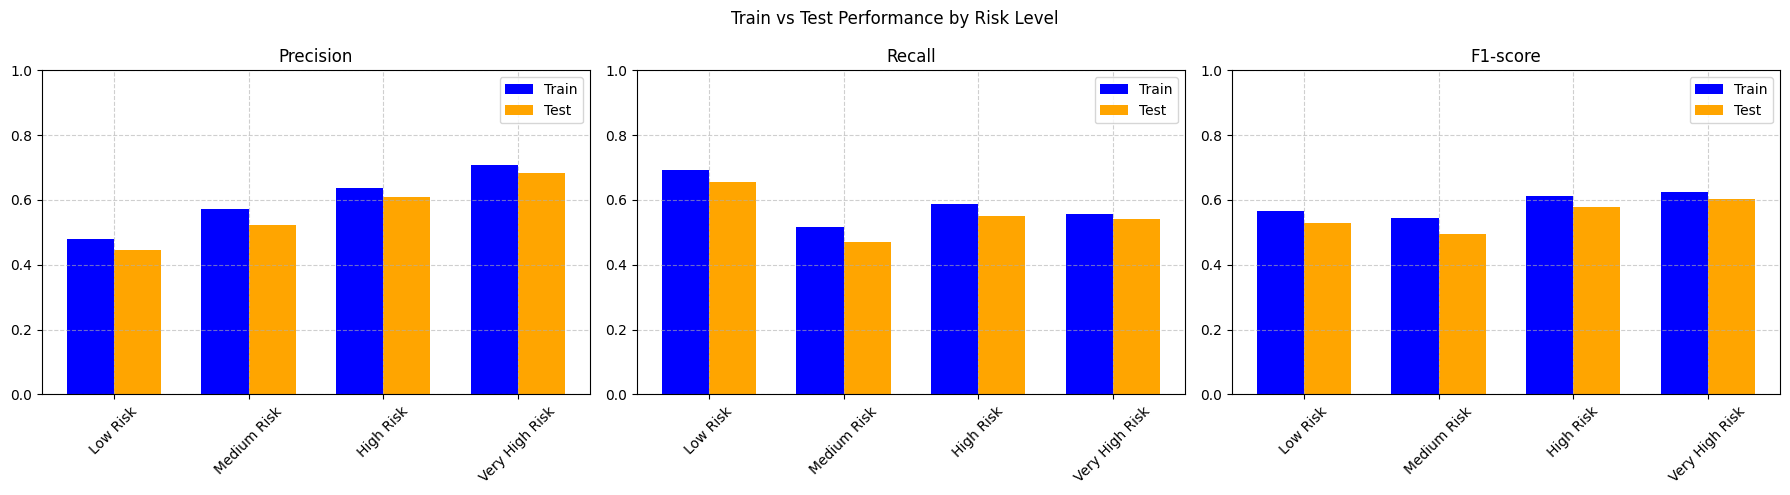

In [ ]:
categories = ['Low Risk', 'Medium Risk', 'High Risk', 'Very High Risk']

train_report = classification_report(y_train, logreg_pipeline.predict(X_train), target_names=categories, output_dict=True)
test_report = classification_report(y_test, logreg_pipeline.predict(X_test), target_names=categories, output_dict=True)

metrics = ['precision', 'recall', 'f1-score']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, metric in enumerate(metrics):
    train_scores = [train_report[cat][metric] for cat in categories]
    test_scores = [test_report[cat][metric] for cat in categories]

    x = np.arange(len(categories))
    width = 0.35

    axes[i].bar(x - width/2, train_scores, width, label='Train', color='blue')
    axes[i].bar(x + width/2, test_scores, width, label='Test', color='orange')
    axes[i].set_title(metric.capitalize())
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(categories, rotation=45)
    axes[i].legend()
    axes[i].set_ylim(0, 1)
    axes[i].grid(True, linestyle='--', alpha=0.6)

plt.suptitle('Train vs Test Performance by Risk Level')
plt.tight_layout()
plt.show()

## CatBoost

In [ ]:
cat_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', CatBoostClassifier(verbose=0, random_state=42))
])

cat_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Vict Age', 'Crm Cd']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['LOCATION', 'Mocodes',
                                                   'Premis Desc',
                                                   'Vict Descent', 'Date Rptd',
                                                   'DATE OCC', 'Crm Cd Desc',
                                                   'Weapon Desc',
                                                   'TIME OCC'])])),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x79c314302c10>)])

In [ ]:
y_pred = cat_pipeline.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


# scores = cross_val_score(cat_pipeline, X, y,  scoring='accuracy')
# print("\nCross-validation accuracy scores:", scores)
# print("Mean accuracy:", scores.mean())


Classification Report:
               precision    recall  f1-score   support

           1       0.43      0.62      0.51      9393
           2       0.56      0.35      0.43      8906
           3       0.60      0.47      0.53      9816
           4       0.56      0.63      0.59     11936

    accuracy                           0.52     40051
   macro avg       0.54      0.52      0.51     40051
weighted avg       0.54      0.52      0.52     40051



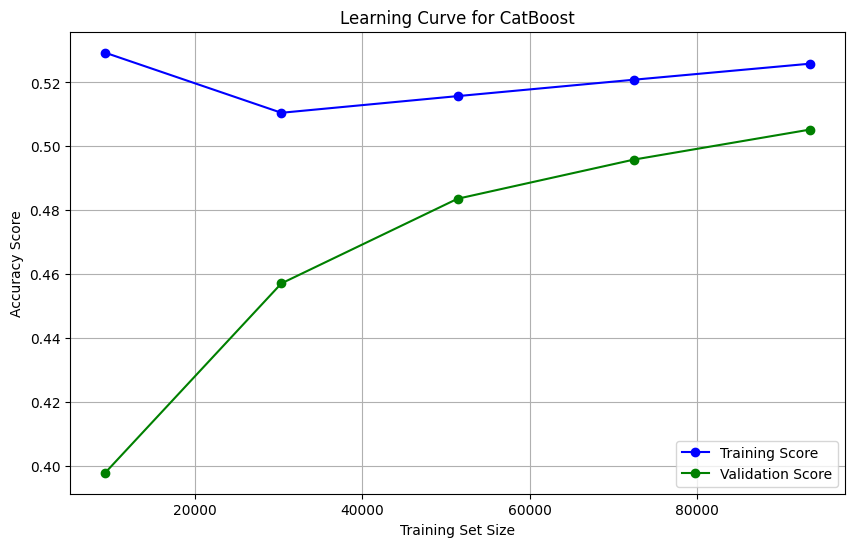

In [ ]:
train_sizes, train_scores, val_scores = learning_curve(
    cat_pipeline,
    X_train,
    y_train,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5),
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)


plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Score')
plt.plot(train_sizes, val_mean, 'o-', color='green', label='Validation Score')
plt.title('Learning Curve for CatBoost')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Score')
plt.legend(loc='best')
plt.grid()
plt.show()

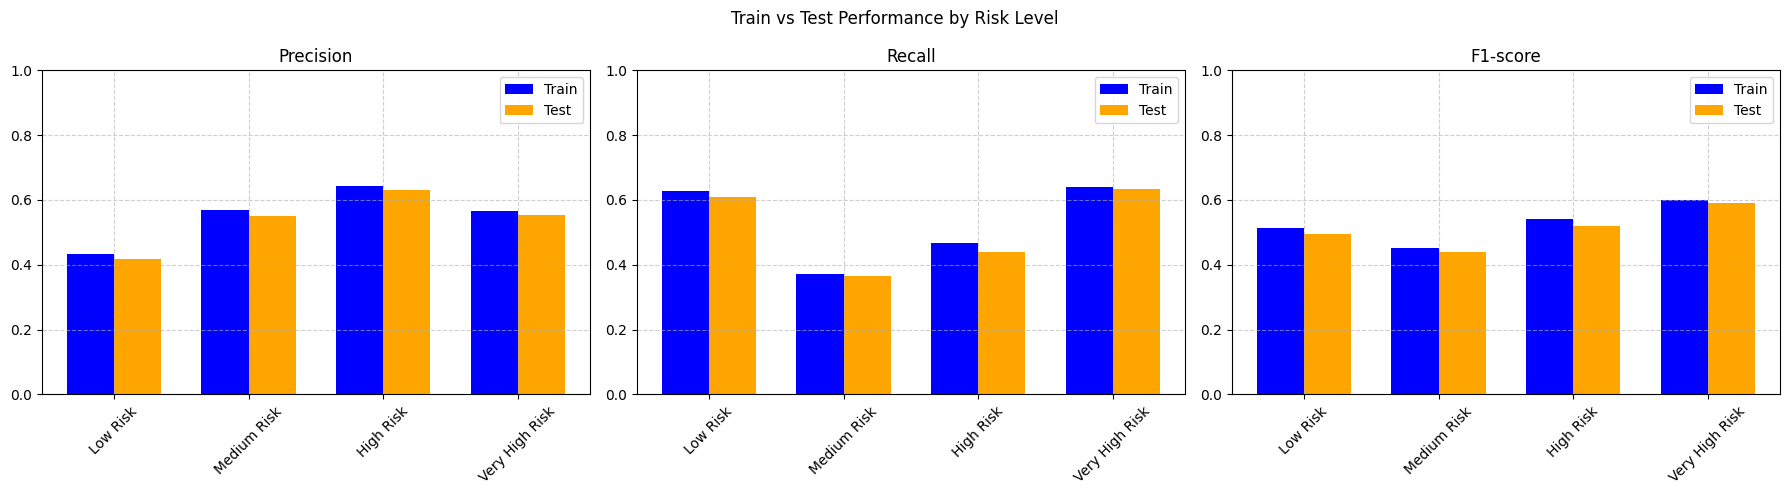

In [ ]:
categories = ['Low Risk', 'Medium Risk', 'High Risk', 'Very High Risk']

train_report = classification_report(y_train, cat_pipeline.predict(X_train), target_names=categories, output_dict=True)
test_report = classification_report(y_test, cat_pipeline.predict(X_test), target_names=categories, output_dict=True)

metrics = ['precision', 'recall', 'f1-score']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, metric in enumerate(metrics):
    train_scores = [train_report[cat][metric] for cat in categories]
    test_scores = [test_report[cat][metric] for cat in categories]

    x = np.arange(len(categories))
    width = 0.35

    axes[i].bar(x - width/2, train_scores, width, label='Train', color='blue')
    axes[i].bar(x + width/2, test_scores, width, label='Test', color='orange')
    axes[i].set_title(metric.capitalize())
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(categories, rotation=45)
    axes[i].legend()
    axes[i].set_ylim(0, 1)
    axes[i].grid(True, linestyle='--', alpha=0.6)

plt.suptitle('Train vs Test Performance by Risk Level')
plt.tight_layout()
plt.show()

## XGBoost

In [ ]:
lb=LabelEncoder()
y=lb.fit_transform(y)

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5 , random_state=42)

In [ ]:
xgb_model = xgb.XGBClassifier(eval_metric='logloss', scale_pos_weight=5)

model=make_pipeline(preprocessor,xgb_model)
model.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Vict Age', 'Crm Cd']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['LOCATION', 'Mocodes',
                                                   'Premis Desc',
                                                   'Vict Descent', 'Date Rptd',
                                                   'DATE OCC', 'Crm Cd Desc',
                                                   'Weapon Desc',
                                                   'TIME OCC'])])),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsa...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

In [ ]:
y_val_pred = model.predict(X_val)

print("Validation Set Performance:")
print(classification_report(y_val, y_val_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

accuracy = accuracy_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred, average='weighted')
roc_auc = roc_auc_score(pd.get_dummies(y_test), pd.get_dummies(y_val_pred), average='weighted')
val_recall_weighted = recall_score(y_val, y_val_pred, average='weighted')


print(f"\nAccuracy: {accuracy:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")
print(f"Recall (weighted): {val_recall_weighted:.4f}")
print(f"ROC AUC Score (weighted): {roc_auc:.4f}")

Validation Set Performance:
              precision    recall  f1-score   support

           0       0.41      0.66      0.51      7191
           1       0.61      0.29      0.39      6588
           2       0.60      0.39      0.47      7432
           3       0.51      0.61      0.55      8827

    accuracy                           0.50     30038
   macro avg       0.53      0.49      0.48     30038
weighted avg       0.53      0.50      0.49     30038


Confusion Matrix:
[[4728  502  617 1344]
 [2202 1927  587 1872]
 [2242  378 2892 1920]
 [2349  370  752 5356]]

Accuracy: 0.4961
F1 Score (weighted): 0.4870
Recall (weighted): 0.4961
ROC AUC Score (weighted): 0.4994


In [ ]:
y_test_pred = model.predict(X_test)

print("\nTest Set Performance (Best Model):")
print(classification_report(y_test, y_test_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

accuracy = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred, average='weighted')
roc_auc = roc_auc_score(pd.get_dummies(y_test), pd.get_dummies(y_test_pred), average='weighted')
test_recall_weighted = recall_score(y_test, y_test_pred, average='weighted')

print(f"\nAccuracy: {accuracy:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")
print(f"Recall (weighted): {test_recall_weighted:.4f}")
print(f"ROC AUC Score (weighted): {roc_auc:.4f}")


Test Set Performance (Best Model):
              precision    recall  f1-score   support

           0       0.40      0.65      0.49      6928
           1       0.61      0.31      0.41      6654
           2       0.60      0.39      0.47      7474
           3       0.52      0.61      0.56      8982

    accuracy                           0.50     30038
   macro avg       0.53      0.49      0.48     30038
weighted avg       0.53      0.50      0.49     30038


Confusion Matrix:
[[4497  505  591 1335]
 [2179 2068  613 1794]
 [2238  392 2909 1935]
 [2392  417  706 5467]]

Accuracy: 0.4974
F1 Score (weighted): 0.4904
Recall (weighted): 0.4974
ROC AUC Score (weighted): 0.6620


In [ ]:
importance = xgb_model.feature_importances_
feature_names = X_train.columns
importance_dict = dict(zip(feature_names, importance))
sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)
for feature, score in sorted_importance:
    print(f"{feature}: {score:.4f}")

LOCATION: 0.0003
Mocodes: 0.0002
Premis Desc: 0.0000
Vict Descent: 0.0000
Date Rptd: 0.0000
DATE OCC: 0.0000
Crm Cd Desc: 0.0000
Vict Age: 0.0000
TIME OCC: 0.0000
Crm Cd: 0.0000
Weapon Desc: 0.0000


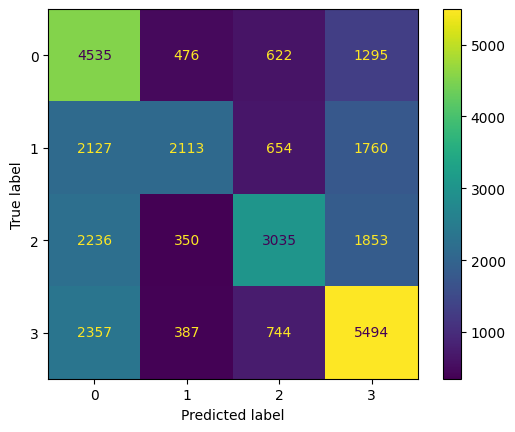

In [ ]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()


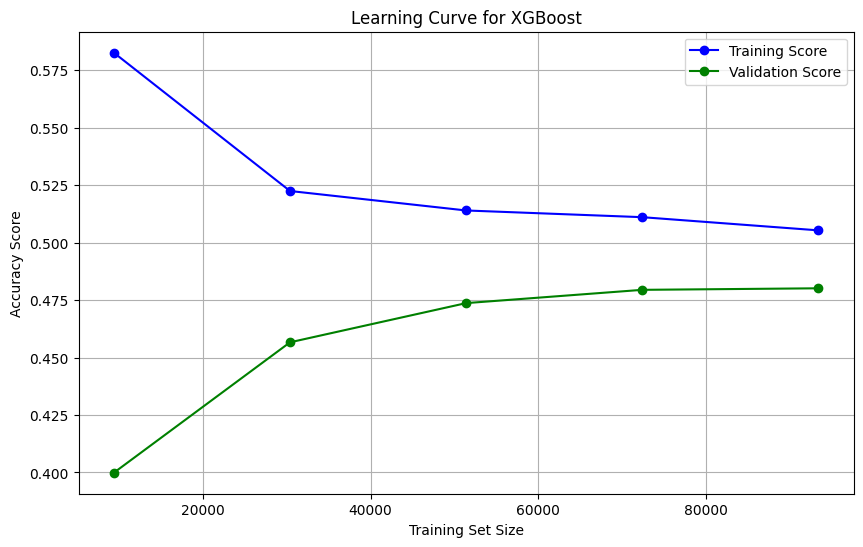

In [ ]:
train_sizes, train_scores, val_scores = learning_curve(
    model,
    X_train,
    y_train,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5),
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)


plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Score')
plt.plot(train_sizes, val_mean, 'o-', color='green', label='Validation Score')
plt.title('Learning Curve for XGBoost')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Score')
plt.legend(loc='best')
plt.grid()
plt.show()

In [ ]:
lgbm_model = LGBMClassifier(
)


lgb_pipeline = make_pipeline(preprocessor, lgbm_model)


lgb_pipeline.fit(X_train, y_train)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 8.176076 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11190
[LightGBM] [Info] Number of data points in the train set: 140175, number of used features: 5488
[LightGBM] [Info] Start training from score -1.451062
[LightGBM] [Info] Start training from score -1.499657
[LightGBM] [Info] Start training from score -1.411514
[LightGBM] [Info] Start training from score -1.208322


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Vict Age', 'Crm Cd']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['LOCATION', 'Mocodes',
                                                   'Premis Desc',
                                                   'Vict Descent', 'Date Rptd',
                                                   'DATE OCC', 'Crm Cd Desc',
                                                   'Weapon Desc',
                                                   'TIME OCC'])])),
                ('lgbmclassifier', LGBMClassifier())])

In [ ]:
y_val_pred = lgb_pipeline.predict(X_val)

print("Validation Set Performance:")
print(classification_report(y_val, y_val_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

accuracy = accuracy_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred, average='weighted')
roc_auc = roc_auc_score(pd.get_dummies(y_test), pd.get_dummies(y_val_pred), average='weighted')

print(f"\nAccuracy: {accuracy:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")
print(f"ROC AUC Score (weighted): {roc_auc:.4f}")

Validation Set Performance:
              precision    recall  f1-score   support

           0       0.41      0.63      0.50      7191
           1       0.50      0.31      0.38      6588
           2       0.56      0.41      0.48      7432
           3       0.55      0.59      0.57      8827

    accuracy                           0.49     30038
   macro avg       0.50      0.49      0.48     30038
weighted avg       0.51      0.49      0.49     30038


Confusion Matrix:
[[4514  766  768 1143]
 [2267 2030  773 1518]
 [2107  683 3079 1563]
 [2139  622  855 5211]]

Accuracy: 0.4938
F1 Score (weighted): 0.4877
ROC AUC Score (weighted): 0.4999


In [ ]:
y_test_pred = lgb_pipeline.predict(X_test)

print("\nTest Set Performance (Best Model):")
print(classification_report(y_test, y_test_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

accuracy = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred, average='weighted')
roc_auc = roc_auc_score(pd.get_dummies(y_test), pd.get_dummies(y_test_pred), average='weighted')

print(f"\nAccuracy: {accuracy:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")
print(f"ROC AUC Score (weighted): {roc_auc:.4f}")


Test Set Performance (Best Model):
              precision    recall  f1-score   support

           0       0.40      0.62      0.48      6928
           1       0.50      0.32      0.39      6654
           2       0.57      0.42      0.49      7474
           3       0.56      0.59      0.57      8982

    accuracy                           0.50     30038
   macro avg       0.51      0.49      0.48     30038
weighted avg       0.51      0.50      0.49     30038


Confusion Matrix:
[[4292  770  714 1152]
 [2281 2136  790 1447]
 [2074  686 3151 1563]
 [2160  668  862 5292]]

Accuracy: 0.4951
F1 Score (weighted): 0.4907
ROC AUC Score (weighted): 0.6624


In [ ]:
importance = lgbm_model.feature_importances_
feature_names = X_train.columns
importance_dict = dict(zip(feature_names, importance))
sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)
for feature, score in sorted_importance:
    print(f"{feature}: {score:.4f}")

LOCATION: 177.0000
Mocodes: 73.0000
Premis Desc: 0.0000
Vict Descent: 0.0000
Date Rptd: 0.0000
DATE OCC: 0.0000
Crm Cd Desc: 0.0000
Vict Age: 0.0000
TIME OCC: 0.0000
Crm Cd: 0.0000
Weapon Desc: 0.0000


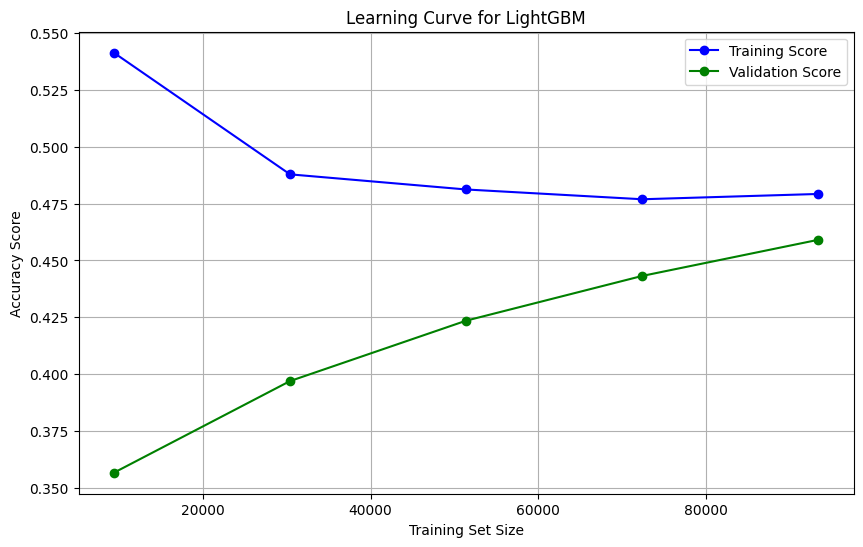

In [ ]:
train_sizes, train_scores, val_scores = learning_curve(
    lgb_pipeline,
    X_train,
    y_train,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5),
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)


plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Score')
plt.plot(train_sizes, val_mean, 'o-', color='green', label='Validation Score')
plt.title('Learning Curve for LightGBM')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Score')
plt.legend(loc='best')
plt.grid()
plt.show()

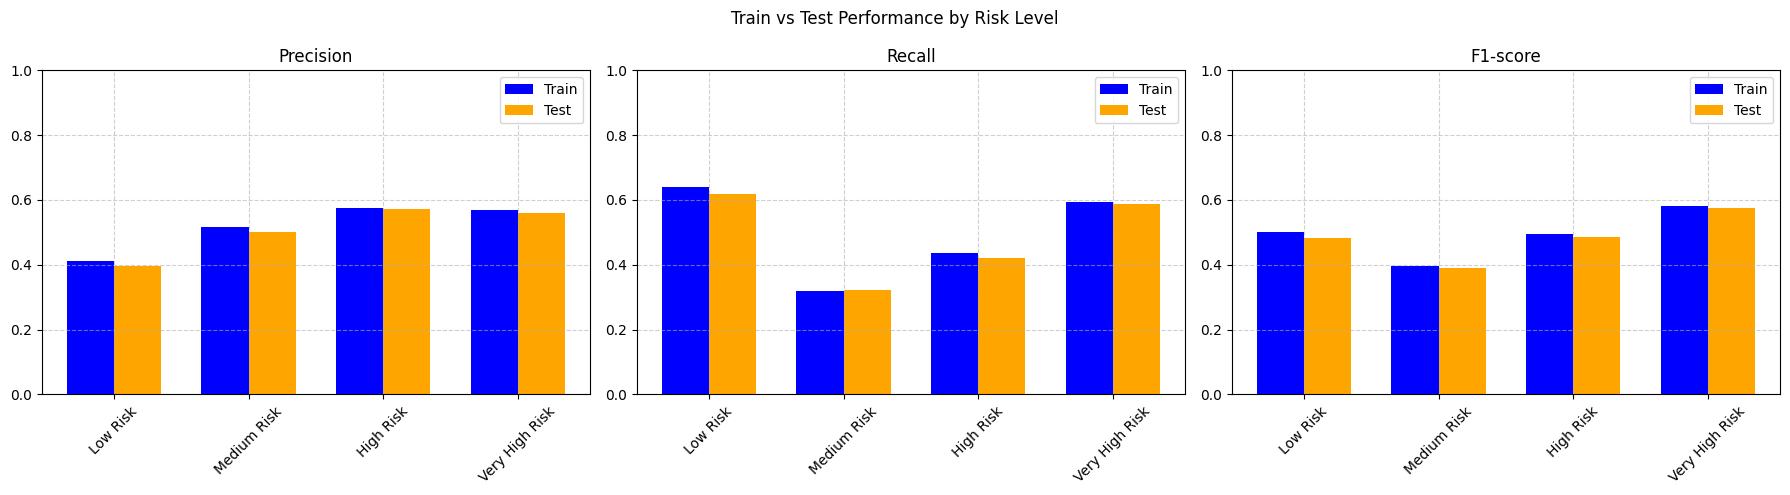

In [ ]:
categories = ['Low Risk', 'Medium Risk', 'High Risk', 'Very High Risk']

train_report = classification_report(y_train, lgb_pipeline.predict(X_train), target_names=categories, output_dict=True)
test_report = classification_report(y_test, lgb_pipeline.predict(X_test), target_names=categories, output_dict=True)

metrics = ['precision', 'recall', 'f1-score']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, metric in enumerate(metrics):
    train_scores = [train_report[cat][metric] for cat in categories]
    test_scores = [test_report[cat][metric] for cat in categories]

    x = np.arange(len(categories))
    width = 0.35

    axes[i].bar(x - width/2, train_scores, width, label='Train', color='blue')
    axes[i].bar(x + width/2, test_scores, width, label='Test', color='orange')
    axes[i].set_title(metric.capitalize())
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(categories, rotation=45)
    axes[i].legend()
    axes[i].set_ylim(0, 1)
    axes[i].grid(True, linestyle='--', alpha=0.6)

plt.suptitle('Train vs Test Performance by Risk Level')
plt.tight_layout()
plt.show()

## Neural Network

In [ ]:
X_encoded = preprocessor.fit_transform(X)

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
y = LabelEncoder().fit_transform(y)

y_cat = to_categorical(y)

X_train, X_temp, y_train, y_temp = train_test_split(X_encoded, y_cat, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5 , random_state=42)

In [ ]:
model = Sequential()
model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1], activation='softmax'))

In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val,y_val),
    epochs=10,
    batch_size=128,
    verbose=2,
    callbacks=[early_stop]
)

Epoch 1/10
1096/1096 - 618s - 563ms/step - accuracy: 0.5195 - loss: 1.0928 - val_accuracy: 0.7374 - val_loss: 0.7001
Epoch 2/10
1096/1096 - 579s - 528ms/step - accuracy: 0.8160 - loss: 0.5064 - val_accuracy: 0.8247 - val_loss: 0.4653
Epoch 3/10
1096/1096 - 629s - 574ms/step - accuracy: 0.9169 - loss: 0.2420 - val_accuracy: 0.8494 - val_loss: 0.4147
Epoch 4/10
1096/1096 - 568s - 519ms/step - accuracy: 0.9538 - loss: 0.1402 - val_accuracy: 0.8570 - val_loss: 0.4077
Epoch 5/10
1096/1096 - 625s - 570ms/step - accuracy: 0.9705 - loss: 0.0918 - val_accuracy: 0.8567 - val_loss: 0.4251
Epoch 6/10
1096/1096 - 557s - 508ms/step - accuracy: 0.9781 - loss: 0.0683 - val_accuracy: 0.8598 - val_loss: 0.4408
Epoch 7/10
1096/1096 - 558s - 509ms/step - accuracy: 0.9822 - loss: 0.0546 - val_accuracy: 0.8609 - val_loss: 0.4551


In [ ]:
y_val_pred = model.predict(X_val)

print("Validation Set Performance:")
print(classification_report(y_val, y_val_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

accuracy = accuracy_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred, average='weighted')
roc_auc = roc_auc_score(pd.get_dummies(y_test), pd.get_dummies(y_val_pred), average='weighted')

print(f"\nAccuracy: {accuracy:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")
print(f"ROC AUC Score (weighted): {roc_auc:.4f}")

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
y_test_pred_prob = model.predict(X_test)
y_test_pred = np.argmax(y_test_pred_prob, axis=1)

if y_test.ndim > 1:
    y_test_true = np.argmax(y_test, axis=1)
else:
    y_test_true = y_test

if y_test_pred.ndim > 1:
    y_test_pred = np.argmax(y_test_pred, axis=1)

print("\nTest Set Performance (Keras Neural Network):")
print(classification_report(y_test_true, y_test_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test_true, y_test_pred))

accuracy = accuracy_score(y_test_true, y_test_pred)
f1 = f1_score(y_test_true, y_test_pred, average='weighted')
roc_auc = roc_auc_score(y_test_true, y_test_pred_prob, average='weighted', multi_class='ovr')

print(f"\nAccuracy: {accuracy:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")
print(f"ROC AUC Score (weighted): {roc_auc:.4f}")

939/939 ━━━━━━━━━━━━━━━━━━━━ 31s 33ms/step

Test Set Performance (Keras Neural Network):
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      6928
           1       0.85      0.82      0.84      6654
           2       0.87      0.87      0.87      7474
           3       0.88      0.88      0.88      8982

    accuracy                           0.86     30038
   macro avg       0.86      0.86      0.86     30038
weighted avg       0.86      0.86      0.86     30038

Confusion Matrix:
[[5894  432  245  357]
 [ 592 5484  282  296]
 [ 239  261 6503  471]
 [ 372  276  436 7898]]

Accuracy: 0.8582
F1 Score (weighted): 0.8582
ROC AUC Score (weighted): 0.9757


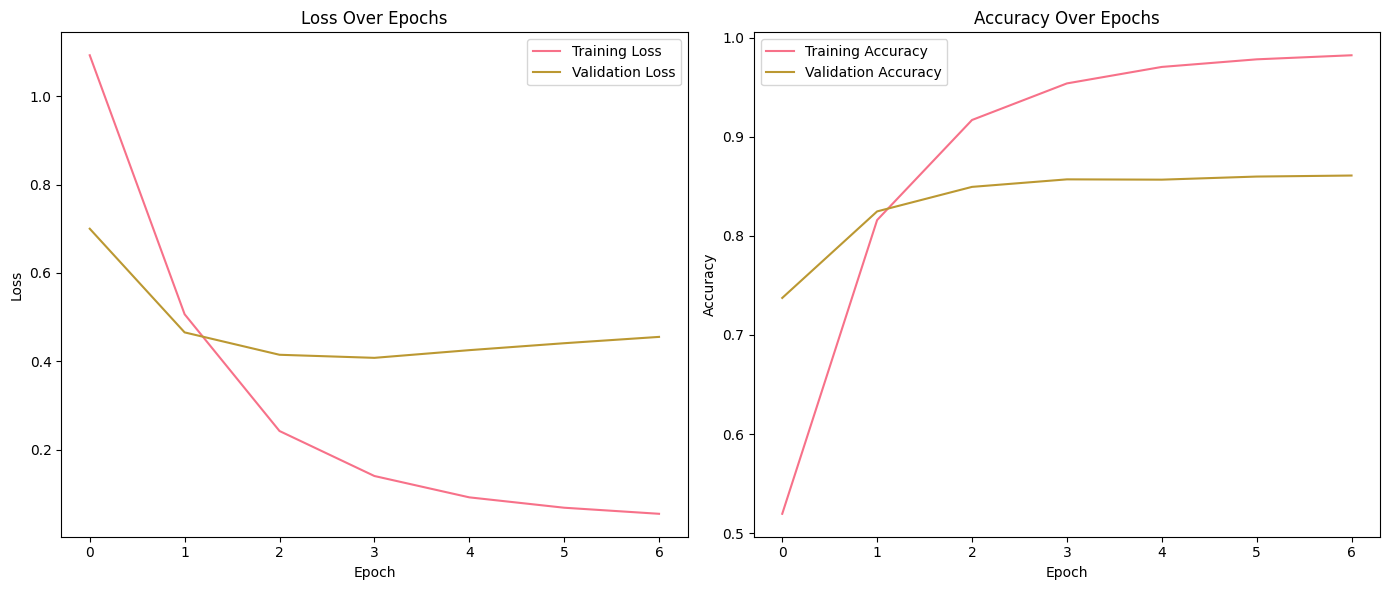

In [ ]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

4381/4381 ━━━━━━━━━━━━━━━━━━━━ 153s 35ms/step


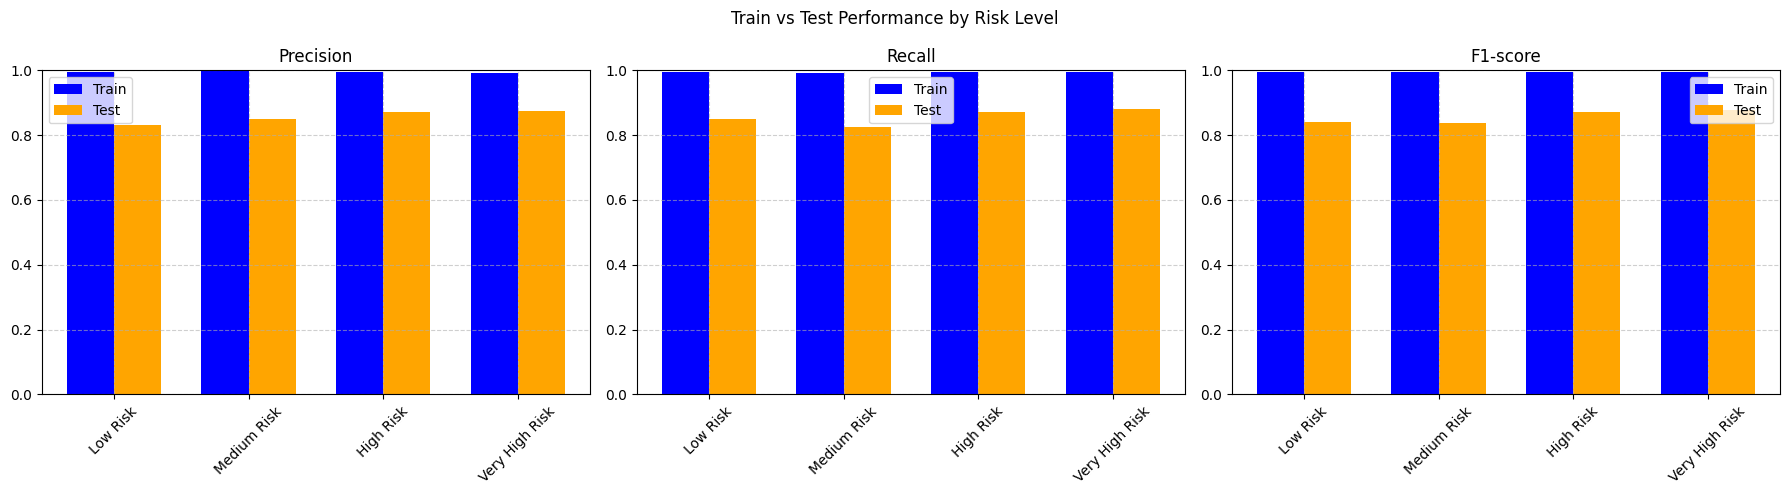

In [ ]:
categories = ['Low Risk', 'Medium Risk', 'High Risk', 'Very High Risk']

y_train_pred_prob = model.predict(X_train)
y_train_pred = np.argmax(y_train_pred_prob, axis=1)

if y_train.ndim > 1:
    y_train_true = np.argmax(y_train, axis=1)
else:
    y_train_true = y_train

if y_train_pred.ndim > 1:
    y_train_pred = np.argmax(y_train_pred, axis=1)

train_report = classification_report(y_train_true, y_train_pred, target_names=categories, output_dict=True)
test_report = classification_report(y_test_true, y_test_pred, target_names=categories, output_dict=True)

metrics = ['precision', 'recall', 'f1-score']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, metric in enumerate(metrics):
    train_scores = [train_report[cat][metric] for cat in categories]
    test_scores = [test_report[cat][metric] for cat in categories]

    x = np.arange(len(categories))
    width = 0.35

    axes[i].bar(x - width/2, train_scores, width, label='Train', color='blue')
    axes[i].bar(x + width/2, test_scores, width, label='Test', color='orange')
    axes[i].set_title(metric.capitalize())
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(categories, rotation=45)
    axes[i].legend()
    axes[i].set_ylim(0, 1)
    axes[i].grid(True, linestyle='--', alpha=0.6)

plt.suptitle('Train vs Test Performance by Risk Level')
plt.tight_layout()
plt.show()

## Stacking(CatBoost + RandomForest)

In [ ]:
from sklearn.linear_model import RidgeCV

cat_model = CatBoostClassifier(
    cat_features=categorical_features,
    learning_rate=0.1,
    depth=10,
    iterations=1000,
    l2_leaf_reg=1,
    bagging_temperature=0,
    random_state=42,
    verbose=0
)


# Random Forest with preprocessing
rf_pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("rf", RandomForestClassifier(
        n_estimators=300,
        max_depth=20,
        random_state=42,
        n_jobs=-1
    ))
])


from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegressionCV

final_estimator = LogisticRegressionCV(cv=3, solver='liblinear')
# ---------------------------
# 6. Stacking Regressor
# ---------------------------
stack_model = StackingClassifier(
    estimators=[
        ("catboost", cat_model),
        ("random_forest", rf_pipeline)
    ],
    final_estimator= final_estimator,
    passthrough=False,
    n_jobs=-1,
    stack_method='auto',
     cv=3
)

# ---------------------------
# 7. Train and Predict
# ---------------------------
stack_model.fit(X_train, y_train)




In [ ]:
y_val_pred = stack_model.predict(X_val)

print("Validation Set Performance:")
print(classification_report(y_val, y_val_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

accuracy = accuracy_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred, average='weighted')
roc_auc = roc_auc_score(pd.get_dummies(y_test), pd.get_dummies(y_val_pred), average='weighted')

print(f"\nAccuracy: {accuracy:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")
print(f"ROC AUC Score (weighted): {roc_auc:.4f}")

In [ ]:
y_pred = stack_model.predict(X_test)

print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

## جدول المقارنة

### مقارنة أداء النماذج وإعدادات المعلمات

| النموذج              | الدقة   | نتيجة F1 (موزونة) | نتيجة ROC AUC (موزونة) | المعلمات الرئيسية                                                                 |
|----------------------|---------|--------------------|-------------------------|-----------------------------------------------------------------------------------|
| الغابة العشوائية     | 0.5155  | 0.5150             | 0.5010                  | عدد الأشجار: 100، العمق: غير محدود، الحد الأدنى للانقسام: 5، الحد الأدنى للأوراق: 2، السمات: sqrt، bootstrap: نعم، class_weight: متوازن |
| الانحدار اللوجستي     | 0.5590  | 0.5608             | 0.4987                  | متعدد الفئات: multinomial، المحلل: saga، العقوبة: elasticnet، l1_ratio: 0.5، C: 0.1، class_weight: متوازن، max_iter: 1000 |
| CatBoost             | 0.5200  | 0.5200             | --                      | الإعدادات الافتراضية، random_state: 42                                          |
| XGBoost              | 0.5061  | 0.4978             | 0.5005                  | الإعدادات الافتراضية، random_state: 42                                          |
| LightGBM             | 0.4938  | 0.4877             | 0.4999                  | الإعدادات الافتراضية                                                            |
| الشبكة العصبية (Keras) | 0.8582  | 0.8582             | 0.9757                  | طبقات: 128 (relu) + Dropout(0.5) + 64 (relu) + Dropout(0.5) + softmax، العصور: 10، حجم الدفعة: 128، توقف مبكر |

# Grid Search

## Grid Search Random Forest

In [ ]:
rf = RandomForestClassifier(
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

rfgrid_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', rf)
])

param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__max_features': ['sqrt', 'log2'],
    'classifier__bootstrap': [True, False]
}

grid_search = GridSearchCV(
    estimator=rfgrid_pipeline,
    param_grid=param_grid,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=3
)

print("Starting Grid Search...")
grid_search.fit(X_train, y_train)

print("\n=== Best Parameters ===")
print(grid_search.best_params_)


Starting Grid Search...
Fitting 3 folds for each of 96 candidates, totalling 288 fits


In [ ]:
y_val_pred = best_model.predict(X_val)

print("Validation Set Performance:")
print(classification_report(y_val, y_val_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

accuracy = accuracy_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred, average='weighted')
roc_auc = roc_auc_score(pd.get_dummies(y_test), pd.get_dummies(y_val_pred), average='weighted')

print(f"\nAccuracy: {accuracy:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")
print(f"ROC AUC Score (weighted): {roc_auc:.4f}")

In [ ]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("\n=== Test Set Performance ===")
print(classification_report(y_test, y_pred,
                          target_names=['Low Risk', 'Medium Risk', 'High Risk', 'Very High Risk']))

In [ ]:
## Feature Importance Visualization
# Get feature names after one-hot encoding
onehot_columns = list(grid_search.best_estimator_.named_steps['preprocessor']
                     .named_transformers_['cat']
                     .get_feature_names_out(categorical_features))
all_feature_names = numeric_features + onehot_columns

# Get importances
importances = best_model.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[::-1]

# Plot top 20 features
plt.figure(figsize=(12, 8))
plt.title("Top 20 Feature Importances")
plt.barh(range(20), importances[indices][:20][::-1], align='center')
plt.yticks(range(20), [all_feature_names[i] for i in indices[:20][::-1]])
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.show()


In [ ]:
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train, y_train, cv=3, scoring='f1_weighted',
    n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5))

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Validation')
plt.title('Learning Curve for Optimized Random Forest')
plt.xlabel('Training Set Size')
plt.ylabel('F1 Score (Weighted)')
plt.legend()
plt.grid()
plt.show()

## Random Search Random Forest

In [ ]:
rf = RandomForestClassifier(
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

rfgrid_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', rf)
])


param_dist = {
    'classifier__n_estimators': [100, 200, 300, 400, 500],
    'classifier__max_depth': [None, 10, 20, 30, 40, 50],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__bootstrap': [True, False],
    'classifier__class_weight': [None, 'balanced', 'balanced_subsample'],
    'classifier__max_features': ['sqrt', 'log2', None],
    'classifier__criterion': ['gini', 'entropy']
}

random_search = RandomizedSearchCV(
    estimator=rfgrid_pipeline,
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings sampled
    cv=5,        # 5-fold cross-validation
    verbose=2,
    n_jobs=-1,   # Use all processors
    scoring='f1_weighted'  # Focus on weighted F1 score
)



random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)

In [ ]:
# Evaluate on validation set
best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_val)

print("\nValidation Set Performance:")
print(classification_report(y_val, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred))

## using Gpu



In [ ]:
!pip uninstall -y \
    libcudf-cu11 libcudf-cu12 \
    libcuml-cu11 libcuml-cu12 \
    librmm-cu11 librmm-cu12 \
    pylibcudf-cu11 pylibcudf-cu12 \
    cudf-polars-cu12

Found existing installation: libcudf-cu11 25.6.0
Uninstalling libcudf-cu11-25.6.0:
  Successfully uninstalled libcudf-cu11-25.6.0
Found existing installation: libcudf-cu12 25.6.0
Uninstalling libcudf-cu12-25.6.0:
  Successfully uninstalled libcudf-cu12-25.6.0
Found existing installation: libcuml-cu11 25.6.0
Uninstalling libcuml-cu11-25.6.0:
  Successfully uninstalled libcuml-cu11-25.6.0
Found existing installation: libcuml-cu12 25.6.0
Uninstalling libcuml-cu12-25.6.0:
  Successfully uninstalled libcuml-cu12-25.6.0
Found existing installation: librmm-cu11 25.6.0
Uninstalling librmm-cu11-25.6.0:
  Successfully uninstalled librmm-cu11-25.6.0
Found existing installation: librmm-cu12 25.6.0
Uninstalling librmm-cu12-25.6.0:
  Successfully uninstalled librmm-cu12-25.6.0
Found existing installation: pylibcudf-cu11 25.6.0
Uninstalling pylibcudf-cu11-25.6.0:
  Successfully uninstalled pylibcudf-cu11-25.6.0
Found existing installation: pylibcudf-cu12 25.6.0
Uninstalling pylibcudf-cu12-25.6.0:
  S

In [ ]:
!pip install \
    cudf-cu12==25.6.0 \
    cuml-cu12==25.6.0 \
    rmm-cu12==25.6.0 \
    dask-cudf-cu12==25.6.0 \
    cupy-cuda12x==13.5.1 \
    --extra-index-url=https://pypi.nvidia.com

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.5/589.5 MB 53.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.7/28.7 MB 177.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.5/202.5 MB 86.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 126.4 MB/s eta 0:00:00


In [ ]:
!pip list | grep -E "cudf|cuml|rmm|cupy|libcudf|libcuml"

cudf-cu12                             25.6.0
cuml-cu12                             25.6.0
cupy-cuda12x                          13.5.1
dask-cudf-cu12                        25.6.0
libcudf-cu12                          25.6.0
libcuml-cu12                          25.6.0
librmm-cu12                           25.6.0
pylibcudf-cu12                        25.6.0
rmm-cu12                              25.6.0


In [ ]:
import cudf
import cupy
from cuml.ensemble import RandomForestClassifier

print(f"cuDF version: {cudf.__version__}")
print(f"CuPy version: {cupy.__version__}")
print("All packages working correctly with CUDA 12.5!")

cuDF version: 25.06.00
CuPy version: 13.5.1
All packages working correctly with CUDA 12.5!


In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from cuml.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
import cudf
import numpy as np


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
    ])


class GPUConverter(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):

        if isinstance(X, np.ndarray):
            return cudf.DataFrame({f'col_{i}': X[:, i] for i in range(X.shape[1])})
        return cudf.DataFrame(X)


pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('converter', GPUConverter()),
    ('classifier', RandomForestClassifier(
        random_state=42,
        n_streams=4,
        n_bins=128
    ))
])


param_dist = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [5, 10, 15, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__max_features': [0.8, 'sqrt', 'log2'],
    'classifier__min_samples_leaf': [1, 2, 4]
}


random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=15,
    cv=3,
    verbose=2,
    scoring='f1_weighted',
    n_jobs=1
)

try:
    random_search.fit(X_train, y_train)

    print("\nBest Parameters:", random_search.best_params_)


    val_pred = random_search.predict(X_val)
    print("\nValidation Report:")
    print(classification_report(y_val, val_pred))


    test_pred = random_search.predict(X_test)
    print("\nTest Report:")
    print(classification_report(y_test, test_pred))

except Exception as e:
    print(f"\nError occurred: {str(e)}")
    print("\nDebugging info:")
    print("X_train shape:", X_train.shape)
    print("y_train unique values:", np.unique(y_train))

Fitting 3 folds for each of 15 candidates, totalling 45 fits
